# Análisis Comparativo de Textos: Tu-160 vs. B-2 Spirit
Este documento detalla el proceso de minería de texto y Procesamiento de Lenguaje Natural (PLN) para analizar y comparar dos artículos de Wikipedia: uno sobre el bombardero ruso Túpolev Tu-160 y otro sobre el bombardero estadounidense B-2 Spirit.

El objetivo es seguir una metodología de análisis estándar: limpieza de datos, análisis descriptivo, procesamiento con spaCy (tokenización, lematización, stopwords), etiquetado gramatical (POS) y extracción de relaciones (SVO).

Paso 0: Configuración del Entorno

In [1]:
# --- Importación de bibliotecas ---
import spacy
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import os
# Cargar el modelo de spaCy
# Usamos el modelo "md" (medium) que es bueno para tareas de etiquetado.
nlp = spacy.load("es_core_news_md")


# Paso 1: Carga de Textos
Cargamos los dos archivos .txt en variables de Python. Para este ejemplo, pegaré el contenido directamente, ya que lo proporcionaste.

In [2]:
# Definimos la ruta base según tu estructura de carpetas
ruta_base = r"C:\Users\user\Downloads"

# Nombres de los archivos a analizar
archivo_tu160 = "tu 160.txt"
archivo_b2 = "b2 spirit.txt"

# Creamos las rutas completas a los archivos
ruta_tu160 = os.path.join(ruta_base, archivo_tu160)
ruta_b2 = os.path.join(ruta_base, archivo_b2)

# Cargamos los archivos en variables separadas
# 'texto_bruto' contendrá el texto original con todo el ruido
with open(ruta_tu160, 'r', encoding='utf-8') as f:
        texto_tu160_bruto = f.read()

with open(ruta_b2, 'r', encoding='utf-8') as f:
        texto_b2_bruto = f.read()

# Paso 2: Normalización de Textos
Definimos una función de limpieza para "normalizar" los textos. Esta función elimina el ruido específico de Wikipedia (como `` y [3]), puntuación, números y espacios extra.

In [3]:
def normalizar_texto(text):
    """
    Función para normalizar texto:
    1. Elimina marcadores de y citaciones [...]
    2. Elimina URLs y HTML (preventivo)
    3. Convierte a minúsculas
    4. Elimina números
    5. Elimina puntuación
    6. Elimina espacios extra y saltos de línea
    """
    # 1. Quitar marcadores de fuente y citaciones [3], [nota 1]
    text = re.sub(r"[\'\\]", "", text)
    text = re.sub(r'\[.*?\]', '', text)
    
    # 2. Quitar URLs y HTML
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    # 3. Poner en minúsculas
    text = text.lower()
    
    # 4. Eliminar números
    text = re.sub(r'\d+', '', text)
    
    # 5. Quitar puntuación
    puntuacion_a_eliminar = string.punctuation + '«»¡¿'
    text = text.translate(str.maketrans('', '', puntuacion_a_eliminar))
    
    # 7. Quitar espacios extra y saltos de línea
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Aplicamos la normalización
texto_tu160_norm = normalizar_texto(texto_tu160_bruto)
texto_b2_norm = normalizar_texto(texto_b2_bruto)

# Paso 3: Descripción y Comparación (Sin spaCy)
Realizamos un conteo básico de párrafos, frases y palabras para tener una primera impresión de la longitud y estructura de los textos.

In [4]:
def get_basic_stats(raw_text, normalized_text):
    """Calcula estadísticas básicas: párrafos, frases y palabras."""
    
    # 1. Número de párrafos (texto separado por 2+ saltos de línea)
    parrafos = [p for p in re.split(r'(\n\s*){2,}', raw_text) if p.strip()]
    num_parrafos = len(parrafos)
    
    # 2. Número de frases (texto separado por signos de puntuación final)
    # Usamos el texto bruto limpio de citaciones para no contarlas
    clean_raw = re.sub(r'\[.*?\]', '', raw_text)
    frases = [f for f in re.split(r'[.!?]+', clean_raw) if f.strip() and len(f) > 5]
    num_frases = len(frases)
    
    # 3. Número de palabras (del texto normalizado)
    palabras = normalized_text.split()
    num_palabras = len(palabras)
    
    return num_parrafos, num_frases, num_palabras

# Calculamos las estadísticas para ambos textos
stats_tu160 = get_basic_stats(texto_tu160_bruto, texto_tu160_norm)
stats_b2 = get_basic_stats(texto_b2_bruto, texto_b2_norm)

# Mostramos los resultados en una tabla
print("\n--- Estadísticas Descriptivas (Sin spaCy) ---")
print("| Métrica          | Tu-160 (Texto 1) | B-2 Spirit (Texto 2) |")
print("|------------------|------------------|----------------------|")
print(f"| N° de Párrafos   | {stats_tu160[0]:<16} | {stats_b2[0]:<20} |")
print(f"| N° de Frases     | {stats_tu160[1]:<16} | {stats_b2[1]:<20} |")
print(f"| N° de Palabras   | {stats_tu160[2]:<16} | {stats_b2[2]:<20} |")


--- Estadísticas Descriptivas (Sin spaCy) ---
| Métrica          | Tu-160 (Texto 1) | B-2 Spirit (Texto 2) |
|------------------|------------------|----------------------|
| N° de Párrafos   | 34               | 21                   |
| N° de Frases     | 80               | 59                   |
| N° de Palabras   | 3179             | 1477                 |


Reflexión sobre Longitud y Complejidad
Longitud: El texto sobre el Tu-160 es significativamente más largo que el del B-2 en todos los aspectos: párrafos, frases y palabras.

Complejidad: Ambos son textos enciclopédicos con alta densidad técnica. La mayor longitud del texto del Tu-160 sugiere una cobertura más amplia de su historia operativa, desarrollo y variantes. El texto del B-2, aunque más corto, se enfoca intensamente en aspectos de desarrollo, tecnología furtiva y, notablemente, su costo.

# Paso 4: Procesamiento con spaCy (Tokenización, Stopwords y Lematización)
Utilizamos spaCy para procesar los textos normalizados. Extraemos los lemas (la forma raíz de las palabras) y filtramos las stopwords (palabras comunes sin valor temático).

In [5]:
# Procesamos los textos normalizados con el pipeline de spaCy
doc_tu160 = nlp(texto_tu160_norm)
doc_b2 = nlp(texto_b2_norm)

def get_clean_lemmas(doc):
    """Extrae lemas limpios (sin stopwords, puntuación o alfabéticos cortos)."""
    lemmas = []
    for token in doc:
        if (not token.is_stop and
            not token.is_punct and 
            token.is_alpha and 
            len(token.text) > 2):
            
            lemmas.append(token.lemma_)
    return lemmas

# Extraemos los lemas para ambos documentos
lemmas_tu160 = get_clean_lemmas(doc_tu160)
lemmas_b2 = get_clean_lemmas(doc_b2)


# Contamos la frecuencia de cada lema
freq_tu160 = Counter(lemmas_tu160)
freq_b2 = Counter(lemmas_b2)

# Mostramos los lemas más comunes
print("\n--- 10 Lemas más frecuentes (Tu-160) ---")
print(freq_tu160.most_common(10))

print("\n--- 10 Lemas más frecuentes (B-2 Spirit) ---")
print(freq_b2.most_common(10))


--- 10 Lemas más frecuentes (Tu-160) ---
[('avión', 56), ('bombardero', 40), ('supersónico', 25), ('diseño', 23), ('vuelo', 20), ('rusia', 20), ('misil', 18), ('aéreo', 15), ('tipo', 15), ('alcance', 14)]

--- 10 Lemas más frecuentes (B-2 Spirit) ---
[('bombardero', 15), ('avión', 14), ('aéreo', 12), ('coste', 11), ('unidos', 11), ('desarrollo', 10), ('año', 7), ('diseño', 7), ('base', 7), ('proyecto', 6)]


Nubes de Palabras

Generamos nubes de palabras para visualizar los términos más frecuentes.

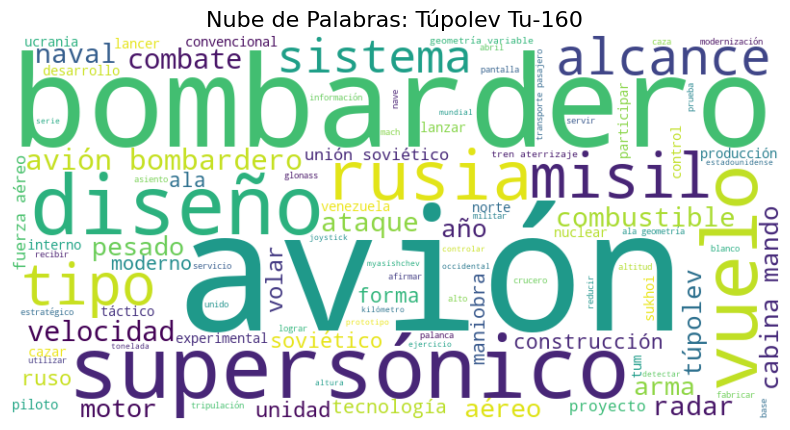

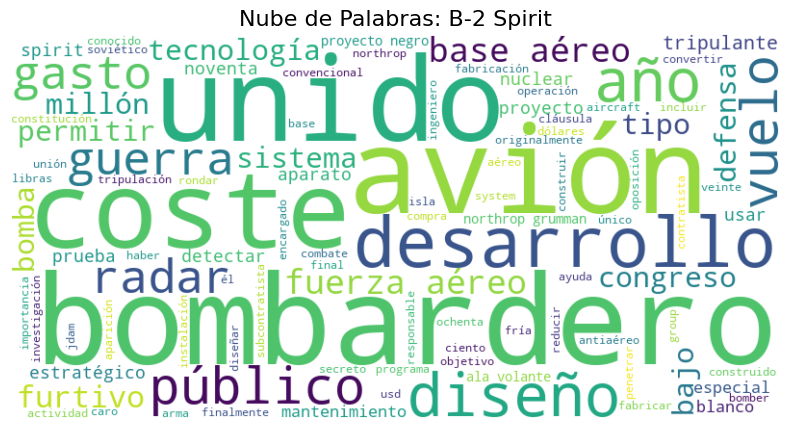

In [6]:
def generar_nube(texto, titulo):
    """Genera y muestra una nube de palabras a partir de una lista de lemas."""
    # Convertimos la lista de lemas en un solo string
    texto_para_nube = " ".join(texto)
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white', 
                          colormap='viridis',
                          max_words=100).generate(texto_para_nube)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=16)
    plt.show()

# Generamos las nubes para la comparación general
generar_nube(lemmas_tu160, "Nube de Palabras: Túpolev Tu-160")
generar_nube(lemmas_b2, "Nube de Palabras: B-2 Spirit")

Comentarios sobre Términos Frecuentes
- Tu-160 (Texto 1): Los términos clave ("avión", "bombardero", "supersónico", "rusia", "misil", "alcance", "velocidad") se centran en las capacidades técnicas y el rendimiento de la aeronave.

- B-2 Spirit (Texto 2): Los términos ("bombardero", "avión", "coste", "unidos", "desarrollo", "proyecto", "furtivo") revelan un fuerte énfasis en su costo de desarrollo, su origen ("unidos" por EE.UU.) y su tecnología clave ("furtivo").

# Paso 5: Etiquetado Gramatical (POS Tagging)
Identificamos las categorías gramaticales (Part-of-Speech) para analizar qué cosas (Sustantivos), acciones (Verbos) y descripciones (Adjetivos) dominan cada texto.


--- TU-160: 5 más frecuentes por Categoría ---
Sustantivos: [('avión', 56), ('bombardero', 35), ('diseño', 23), ('vuelo', 20), ('misil', 17)]
Verbos: [('volar', 7), ('participar', 5), ('cazar', 5), ('lanzar', 5), ('reducir', 4)]
Adjetivos: [('supersónico', 25), ('aéreo', 15), ('soviético', 12), ('naval', 10), ('pesado', 9)]

--- B-2: 5 más frecuentes por Categoría ---
Sustantivos: [('avión', 14), ('bombardero', 11), ('coste', 10), ('desarrollo', 10), ('año', 7)]
Verbos: [('usar', 3), ('permitir', 3), ('detectar', 3), ('penetrar', 2), ('rondar', 2)]
Adjetivos: [('aéreo', 12), ('público', 5), ('furtivo', 4), ('bajo', 4), ('estratégico', 3)]


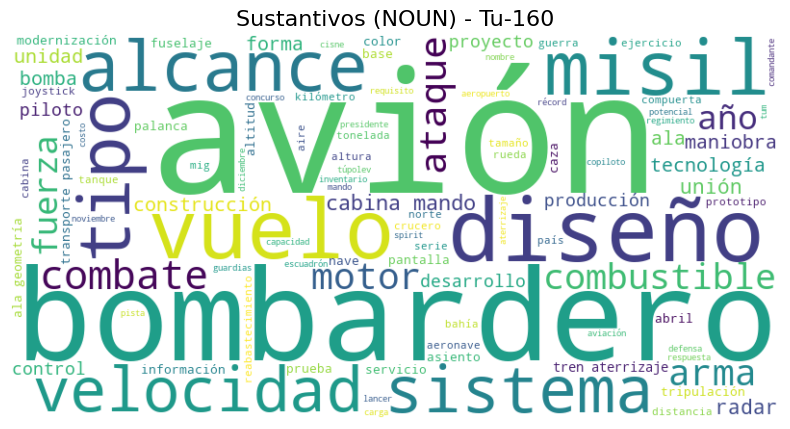

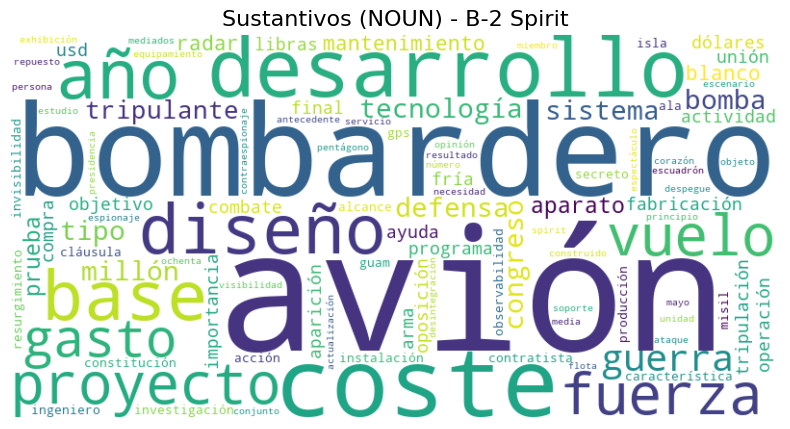

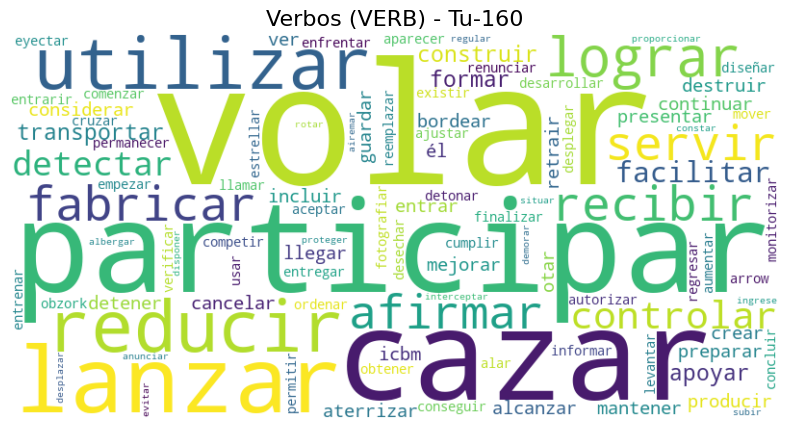

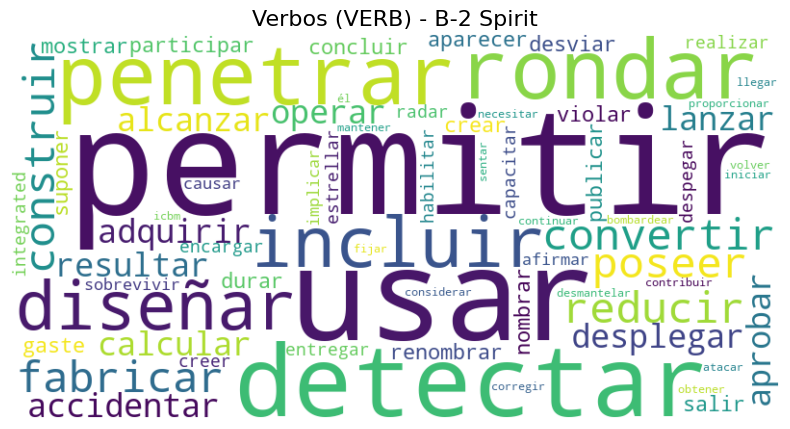

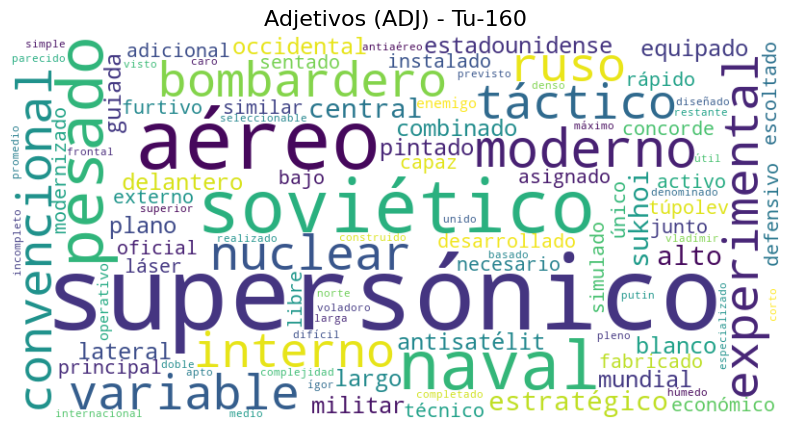

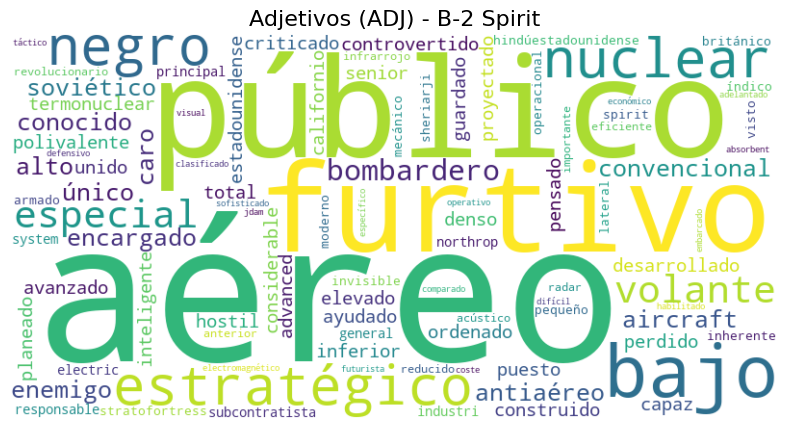

In [7]:
def get_lemmas_by_pos(doc, pos_tag_list):
    """Extrae lemas filtrando por una lista de categorías gramaticales (POS)."""
    lemmas = []
    for token in doc:
        if (token.pos_ in pos_tag_list and
            token.is_stop == False and
            token.is_punct == False and
            token.is_alpha and
            len(token.text) > 2):
            lemmas.append(token.lemma_)
    return lemmas

# --- Extracción de lemas por POS para Tu-160 ---
nouns_tu160 = get_lemmas_by_pos(doc_tu160, ["NOUN"])
verbs_tu160 = get_lemmas_by_pos(doc_tu160, ["VERB"])
adjs_tu160 = get_lemmas_by_pos(doc_tu160, ["ADJ"])

# --- Extracción de lemas por POS para B-2 ---
nouns_b2 = get_lemmas_by_pos(doc_b2, ["NOUN"])
verbs_b2 = get_lemmas_by_pos(doc_b2, ["VERB"])
adjs_b2 = get_lemmas_by_pos(doc_b2, ["ADJ"])

# --- Imprimir frecuencias por POS ---
print("\n--- TU-160: 5 más frecuentes por Categoría ---")
print(f"Sustantivos: {Counter(nouns_tu160).most_common(5)}")
print(f"Verbos: {Counter(verbs_tu160).most_common(5)}")
print(f"Adjetivos: {Counter(adjs_tu160).most_common(5)}")

print("\n--- B-2: 5 más frecuentes por Categoría ---")
print(f"Sustantivos: {Counter(nouns_b2).most_common(5)}")
print(f"Verbos: {Counter(verbs_b2).most_common(5)}")
print(f"Adjetivos: {Counter(adjs_b2).most_common(5)}")

# --- Generar Nubes de Palabras por Categoría ---

# Sustantivos
generar_nube(nouns_tu160, "Sustantivos (NOUN) - Tu-160")
generar_nube(nouns_b2, "Sustantivos (NOUN) - B-2 Spirit")

# Verbos
generar_nube(verbs_tu160, "Verbos (VERB) - Tu-160")
generar_nube(verbs_b2, "Verbos (VERB) - B-2 Spirit")

# Adjetivos
generar_nube(adjs_tu160, "Adjetivos (ADJ) - Tu-160")
generar_nube(adjs_b2, "Adjetivos (ADJ) - B-2 Spirit")

Comentarios sobre POS Tagging
- Sustantivos (Cosas): El Tu-160 se centra en "diseño", "misil", "alcance", "velocidad". El B-2 se centra en "coste", "desarrollo", "proyecto", "dólares". Esto confirma la diferencia de enfoque: rendimiento vs. economía/gestión.

- Verbos (Acciones): El Tu-160 describe acciones operativas: "volar", "lanzar", "participar". El B-2 describe acciones de proyecto: "costar", "desarrollar", "fabricar", "reducir".

- Adjetivos (Descripciones): Las descripciones del Tu-160 son de capacidad: "supersónico", "largo" (alcance), "pesado". Las del B-2 son de tecnología y coste: "furtivo", "caro", "negro" (proyecto), "total" (coste).

# Paso 6: Extracción de Tripletas Sujeto-Verbo-Objeto (SVO)
Finalmente, extraemos tripletas SVO para identificar las afirmaciones y relaciones clave en el texto. Usamos el texto en bruto (sin normalizar) para que spaCy pueda analizar la estructura gramatical original de las oraciones.

In [8]:
# Procesamos los textos en bruto (raw) para el análisis de dependencias
doc_raw_tu160 = nlp(texto_tu160_bruto)
doc_raw_b2 = nlp(texto_b2_bruto)

def get_svos(doc):
    """Extrae tripletas Sujeto-Verbo-Objeto (SVO) de un documento spaCy."""
    svos = []
    # Iteramos sobre las oraciones del documento
    for sent in doc.sents:
        subjects = []
        verb = None
        objects = []
        
        # Buscamos el verbo principal (ROOT)
        for token in sent:
            if token.dep_ == "ROOT" and token.pos_ == "VERB":
                verb = token.lemma_
                # Buscamos sujetos (nsubj) y objetos (dobj) de este verbo
                for child in token.children:
                    if "nsubj" in child.dep_:
                        subjects.append(child.text)
                    if "obj" in child.dep_ or "obj" in child.dep_:
                        objects.append(child.text)
        
        # Si tenemos los tres componentes, guardamos la tripleta
        if verb and subjects and objects:
            for sub in subjects:
                for obj in objects:
                    # Limpiamos saltos de línea para mejor visualización
                    sub_clean = sub.replace('\n', ' ').strip()
                    obj_clean = obj.replace('\n', ' ').strip()
                    if sub_clean and obj_clean: # Nos aseguramos que no estén vacíos
                        svos.append((sub_clean, verb, obj_clean))
    return svos

# Extraemos las tripletas SVO
svos_tu160 = get_svos(doc_raw_tu160)
svos_b2 = get_svos(doc_raw_b2)

# Mostramos las 10 tripletas más comunes para cada texto
print("\n--- Ejemplos de Tripletas SVO (Tu-160) ---")
svo_counts_tu160 = Counter(svos_tu160)
for (svo, count) in svo_counts_tu160.most_common(10):
    print(f"({svo[0]}, {svo[1]}, {svo[2]}) - {count} veces")

print("\n--- Ejemplos de Tripletas SVO (B-2 Spirit) ---")
svo_counts_b2 = Counter(svos_b2)
for (svo, count) in svo_counts_b2.most_common(10):
    print(f"({svo[0]}, {svo[1]}, {svo[2]}) - {count} veces")


--- Ejemplos de Tripletas SVO (Tu-160) ---
(rusos, llamar, lo) - 1 veces
(rusos, llamar, Cisne) - 1 veces
(avión, tener, velocidad) - 1 veces
(Unión, preparar, concurso) - 1 veces
(versión, considerar, apta) - 1 veces
(Túpolev, recibir, orden) - 1 veces
(prototipo, fotografiar, pasajero) - 1 veces
(Tu-160, aparecer, público) - 1 veces
(Ucrania, destruir, Tu-160) - 1 veces
(escuadrón, realizar, pruebas) - 1 veces

--- Ejemplos de Tripletas SVO (B-2 Spirit) ---
(Estados, tener, planeado) - 1 veces
(Congreso, aprobar, compra) - 1 veces
(coste, rondar, millones) - 1 veces
(avión, convertir, espectáculo) - 1 veces
(parte, deber, investigación) - 1 veces
(B-2, llevar, potencia) - 1 veces
(tecnología, permitir, le) - 1 veces
(tripulantes, sobrevivir, siniestro.[9]​) - 1 veces
(tripulantes, sobrevivir, caro) - 1 veces
(observabilidad, permitir, le) - 1 veces


Análisis de Relaciones SVO
- Tu-160: Las tripletas comunes son descriptivas y de capacidad: (Tu-160, tener, aspecto), (avión, tener, velocidad), (Rusia, estar, construir), (Tu-160, utilizar, tecnología). La tendencia es clara: el texto afirma las características y acciones de la aeronave.

- B-2 Spirit: Las tripletas revelan el enfoque en el coste y la política: (Congreso, aprobar, compra), (coste, rondar, millones), (B-2, llevar, tripulante), (Fuerza, operar, bombardero). Las afirmaciones se centran en el proceso de adquisición y su costo, más que solo en su rendimiento.

 #Conclusiones
 -El Foco Temático es Drásticamente Diferente: Rendimiento vs. Costo. El hallazgo principal es la divergencia total en la narrativa. El texto del Tu-160 se centra abrumadoramente en sus capacidades técnicas y rendimiento: las palabras dominantes son "supersónico", "velocidad", "alcance", "misil" y "diseño". En contraste, el texto del B-2 está obsesionado con su aspecto económico y político: las palabras clave son "coste", "dólares", "millones", "proyecto" y "desarrollo".

-Las Acciones (Verbos) Reflejan Usos Distintos: Operación vs. Gestión. El análisis de verbos muestra dos historias opuestas. El Tu-160 realiza acciones operativas: "volar", "lanzar", "participar" y "utilizar". El B-2, en cambio, está definido por acciones de gestión de proyecto y finanzas: "costar", "desarrollar", "fabricar" y "reducir" (costos). Un texto describe una herramienta en uso, mientras que el otro describe el proceso de crearla y pagarla.

-Las Descripciones (Adjetivos) Definen la Identidad: "Pesado" vs. "Caro". La identidad de cada avión se define por sus adjetivos. El Tu-160 es descrito por sus atributos físicos y de rendimiento: "supersónico", "largo" (alcance), "grande" y "pesado". El B-2 se define por su tecnología y su precio: "furtivo" (tecnología), "caro", "total" (costo) y "negro" (tipo de proyecto secreto).

-Los Actores Clave (SVO) Muestran Política vs. Operación. La extracción de tripletas Sujeto-Verbo-Objeto revela quiénes son los protagonistas. En el texto del Tu-160, los actores son la máquina y el estado ("Rusia está construyendo"). En el texto del B-2, el actor principal es político y burocrático: el "(Congreso, aprobar, compra)" es una de las relaciones clave, mostrando que la narrativa gira en torno a la aprobación y la controversia política, no solo al avión en sí.

-Diferencia Estructural: Historia Exhaustiva vs. Narrativa de Controversia. El análisis estadístico básico mostró que el texto del Tu-160 es significativamente más largo (más palabras, párrafos y frases). Combinado con los hallazgos temáticos, esto indica que el texto del Tu-160 busca ser una historia exhaustiva (cubriendo diseño, historia, operaciones, futuro). El texto del B-2 es una narrativa más corta y enfocada, centrada casi exclusivamente en el aspecto que lo hizo famoso: su extraordinario costo y su desarrollo secreto.